Arpitha Gurumurthy </br>
Team: Amalgam
# **Factor: Style Based approaches for fake news detection**
There are mainly two typical categories of style-based
methods: 
* Deception-oriented
  * Deception-oriented stylometric methods capture the
deceptive statements or claims from news content.
  * Rhetorical structure theory can be utilized to capture
the differences between deceptive and truthful sentences
*  Objectivity-oriented
  * Objectivity-oriented approaches capture style signals
that can indicate a decreased objectivity of news content
and thus the potential to mislead consumers, such
as hyperpartisan styles and yellow-journalism.



### Micro factors for Style based based on the above stated points:
* Hyperpartisan: Extremely one sided
* Yellow Journalism: relying on eye-catching headlines
* Rhetorical structure theory (for future work)

### Articles for reference:
* https://arxiv.org/pdf/1708.01967.pdf
* https://arxiv.org/pdf/1702.05638.pdf


This notebook focuses on implementing the microsfactor - yellow journalism.
### Yellow Journalism:
* Yellow journalism is the use of sensationalized news in newspaper published to attract readers and increase circulation.
* journalism that is based upon sensationalism and crude exaggeration.
* present little or no legitimate, well-researched news while instead using eye-catching headlines for increased sales. Techniques may include **exaggerations** of news events, **scandal-mongering**, or **sensationalism**


Using Textstat for feature engineering - Textstat is an easy to use library to calculate statistics from text. It helps determine readability, complexity, and grade level.



In [ ]:
pip install textstat

     |████████████████████████████████| 102kB 6.1MB/s 
     |████████████████████████████████| 1.9MB 28.9MB/s 


In [ ]:
#Importing data from google sheets - politifact dataset
from io import BytesIO
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.cluster import KMeans
import seaborn as sns
import tensorflow.compat.v1 as tf
import textstat
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vQVJo_78TSysSLLSEuvV46wz4_jcj1HJsRHlh5gxPD233XIC7k7Vs1fYy4JdWi7Nt9iHLZBoXNiPtQd/pub?gid=886973267&single=true&output=csv')
data = r.content
df_politifact = pd.read_csv(BytesIO(data))
df_politifact = df_politifact.drop(columns='Unnamed: 0', axis=1)
df_politifact = df_politifact.rename(columns={'Comment':'Text'})

In [ ]:
df_politifact.head()

,Author,Text,Source,DatePublished,Category,BinaryTarget
0,Madeline Heim,Says it doesn't make sense for young adults to...,Tom Tiffany,"April 8, 2021",barely-true,FAKE
1,Tom Kertscher,“Former Las Vegas Raiders offensive tackle Bru...,Facebook posts,"April 7, 2021",FALSE,FAKE
2,Louis Jacobson,President Joe Biden’s infrastructure proposal ...,Pete Buttigieg,"April 7, 2021",mostly-true,FAKE
3,Tom Kertscher,"Colorado “requires photo ID to vote in person,...",Facebook posts,"April 7, 2021",half-true,FAKE
4,Bill McCarthy,"""Sunday was never used before as a voting day ...",Edward Lawrence,"April 7, 2021",FALSE,FAKE


In [ ]:
df_politifact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Author         4500 non-null   object
 1   Text           4500 non-null   object
 2   Source         4500 non-null   object
 3   DatePublished  4500 non-null   object
 4   Category       4500 non-null   object
 5   BinaryTarget   4500 non-null   object
dtypes: object(6)
memory usage: 211.1+ KB


In [ ]:
df_politifact.shape

(4500, 6)

## **EDA and Feature Engineering**

In [ ]:
##Dropping the columns that is not required in this usecase
df_politifact = df_politifact.drop(columns='BinaryTarget', axis = 1)

In [ ]:
type(df_politifact['Text'][0])

str

In [ ]:
# df_politifact.Text = df_politifact.Text.apply(str)

Textstat - Flesch Reading Ease
Returns the Flesch Reading Ease Score.

The following table defines the values for the same.

The table is an example of values. While the maximum score is 121.22, there is no limit on how low the score can be. A negative score is also valid.

Score	Difficulty:

* 90-100	Very Easy
* 80-89	Easy
* 70-79	Fairly Easy
* 60-69	Standard
* 50-59	Fairly Difficult
* 30-49	Difficult
* 0-29	Very Confusing

In [ ]:
##Creating a feature to score the text with a readability factor
df_politifact['flesch'] = df_politifact['Text'].apply(textstat.flesch_reading_ease)

In [ ]:
##Since the flesch reading score is now inversely proportional to the yellowness factor
##we substract its value from the highest - 121.22
df_politifact['flesch'] = 121.22 - df_politifact['flesch'] 

In [ ]:
#function to find if string contains a question and if so, create new feature with a 1 for yes or 0 for no
question_words = ['who','what','where','why','when','whose','whom','would','will','how','which','should','could']

def is_question(text):
    if "?" in text or text.startswith(('who','what','where','why','when','whose','whom','would','will','how','which','should','could','did','do')):
        return 1
    else: 
        return 0
df_politifact['text_lower']=df_politifact['Text'].apply(lambda x: x.lower())
df_politifact['is_q']=df_politifact['text_lower'].apply(is_question)
df_politifact = df_politifact.drop(columns='text_lower')

In [ ]:
df_politifact['is_q'].value_counts()

0    4389
1     111
Name: is_q, dtype: int64

In [ ]:
#create function to find if headline contains '!' and create new feature with 1 for yes and 0 for no
def is_exclamation(headline):
    if "!" in headline: 
        return 1
    else: 
        return 0
df_politifact['is_exclam']=df_politifact['Text'].apply(is_exclamation)

In [ ]:
df_politifact['is_exclam'].value_counts()

0    4353
1     147
Name: is_exclam, dtype: int64

In [ ]:
#create function to find if headline contains '$' and create new feature with 1 for yes and 0 for no
def is_money_related(headline):
    if "$" in headline: 
        return 1
    else: 
        return 0
df_politifact['is_money']=df_politifact['Text'].apply(is_money_related)

In [ ]:
df_politifact['is_money'].value_counts()

0    4281
1     219
Name: is_money, dtype: int64

In [ ]:
#create function to find if headline starts with a digit and create new feature with 1 for yes and 0 for no
def starts_with_num(text):
    if text.startswith(('1','2','3','4','5','6','7','8','9')): 
        return 1
    else: 
        return 0

df_politifact['starts_num']=df_politifact['Text'].apply(starts_with_num)

In [ ]:
df_politifact['starts_num'].value_counts()

0    4497
1       3
Name: starts_num, dtype: int64

In [ ]:
##Calculating the number of words in each text 
df_politifact['num_words'] = df_politifact['Text'].apply(lambda x: len(x.split()))

In [ ]:
##testing function for number of ALL CAPS words in each text
sum(map(str.isupper, df_politifact['Text'][500].split())) 

0

In [ ]:
##Creating a new feature to store the number of ALL CAPS words in each text
df_politifact['All_Caps'] = df_politifact['Text'].apply(lambda x: sum(map(str.isupper, x.split())))

In [ ]:
df_politifact['All_Caps'].value_counts()

0     3042
1     1101
2      249
3       66
5       15
4       15
14       6
10       3
6        3
Name: All_Caps, dtype: int64

In [ ]:
df_politifact.head()

,Author,Text,Source,DatePublished,Category,flesch,is_q,is_exclam,is_money,starts_num,num_words,All_Caps
0,Madeline Heim,Says it doesn't make sense for young adults to...,Tom Tiffany,"April 8, 2021",barely-true,45.34,0,0,0,0,29,0
1,Tom Kertscher,“Former Las Vegas Raiders offensive tackle Bru...,Facebook posts,"April 7, 2021",FALSE,77.83,0,0,0,0,11,0
2,Louis Jacobson,President Joe Biden’s infrastructure proposal ...,Pete Buttigieg,"April 7, 2021",mostly-true,61.92,0,0,0,0,24,0
3,Tom Kertscher,"Colorado “requires photo ID to vote in person,...",Facebook posts,"April 7, 2021",half-true,87.30,0,0,0,0,37,1
4,Bill McCarthy,"""Sunday was never used before as a voting day ...",Edward Lawrence,"April 7, 2021",FALSE,52.45,0,0,0,0,11,0


Calculating the Sentiment score for each record

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
##Looping to pass every headline into the analyser, a sentiment score is assigned to each headline.
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for headline in df_politifact['Text']:
    pol_score = sia.polarity_scores(headline)
    pol_score['headline'] = headline
    results.append(pol_score)

results

[{'compound': -0.5267,
  'headline': 'Says it doesn\'t make sense for young adults to get the vaccine since they "really are not under that much of a threat as a result of this virus."',
  'neg': 0.116,
  'neu': 0.884,
  'pos': 0.0},
 {'compound': -0.4588,
  'headline': '“Former Las Vegas Raiders offensive tackle Bruce Campbell involved in altercation.”',
  'neg': 0.231,
  'neu': 0.769,
  'pos': 0.0},
 {'compound': 0.4215,
  'headline': 'President Joe Biden’s infrastructure proposal “is fully paid for. Across 15 years, it would raise all of the revenue needed for these once-in-a-lifetime investments."',
  'neg': 0.0,
  'neu': 0.891,
  'pos': 0.109},
 {'compound': 0.4019,
  'headline': 'Colorado “requires photo ID to vote in person, requires signature verification for mail-in ballots, which Georgia got rid of, and prevents campaign workers from giving food, water to voters within 100 feet if they’re wearing campaign apparel.”',
  'neg': 0.0,
  'neu': 0.904,
  'pos': 0.096},
 {'compound'

In [ ]:
##Concatenating this list to our original dataframe, only interested in the values of the ‘compound’ variable.
df_politifact['Sentiment_Score'] = pd.DataFrame(results)['compound']

In [ ]:
df_politifact.head()

,Author,Text,Source,DatePublished,Category,flesch,is_q,is_exclam,is_money,starts_num,num_words,All_Caps,Sentiment_Score
0,Madeline Heim,Says it doesn't make sense for young adults to...,Tom Tiffany,"April 8, 2021",barely-true,45.34,0,0,0,0,29,0,-0.5267
1,Tom Kertscher,“Former Las Vegas Raiders offensive tackle Bru...,Facebook posts,"April 7, 2021",FALSE,77.83,0,0,0,0,11,0,-0.4588
2,Louis Jacobson,President Joe Biden’s infrastructure proposal ...,Pete Buttigieg,"April 7, 2021",mostly-true,61.92,0,0,0,0,24,0,0.4215
3,Tom Kertscher,"Colorado “requires photo ID to vote in person,...",Facebook posts,"April 7, 2021",half-true,87.30,0,0,0,0,37,1,0.4019
4,Bill McCarthy,"""Sunday was never used before as a voting day ...",Edward Lawrence,"April 7, 2021",FALSE,52.45,0,0,0,0,11,0,0.0000


## **Defining the Yellowness quotient**


* **flesch_reading_ease** : tells us how convoluted the sentence is. The more confusing the sentence is, the more is its yellowness. We divide the value by 10 and add it towards the yellowness score.
* **is_q** : Tells us whether the text contains a question. More the questions, more the yellowness. This features gets a weight of 5.
* **is_exclam** : Tells us whether the text contains an exclamation. This features gets a weight of 10.
* **is_money** : Tells us whether the text has money relation information. This features gets a weight of 5.
* **starts_num** : Tells us whether if the text start with a number. This features gets a weight of 5.
* **All_Caps** : Tells us whether if the text contains all uppercase words. This features gets a weight of 20, since it depicts sensationalism.
* **Sentiment_Score** : A lot of emotion is captured in sensationalized text. We take the magnitude (postive and negative) of this score and add it to yellowness score.


In [ ]:
##Calculating the yellowness factor
df_politifact['yellowness'] = df_politifact['flesch']/10 \
                              + df_politifact['is_q'] * 5 \
                              + df_politifact['is_exclam'] * 10 \
                              + df_politifact['is_money'] * 5 \
                              + df_politifact['starts_num'] * 5 \
                              + df_politifact['All_Caps'] * 20 \
                              + abs(df_politifact['Sentiment_Score']) * 100
                              

In [ ]:
df_politifact.head()

,Author,Text,Source,DatePublished,Category,flesch,is_q,is_exclam,is_money,starts_num,num_words,All_Caps,Sentiment_Score,yellowness
0,Madeline Heim,Says it doesn't make sense for young adults to...,Tom Tiffany,"April 8, 2021",barely-true,45.34,0,0,0,0,29,0,-0.5267,57.204
1,Tom Kertscher,“Former Las Vegas Raiders offensive tackle Bru...,Facebook posts,"April 7, 2021",FALSE,77.83,0,0,0,0,11,0,-0.4588,53.663
2,Louis Jacobson,President Joe Biden’s infrastructure proposal ...,Pete Buttigieg,"April 7, 2021",mostly-true,61.92,0,0,0,0,24,0,0.4215,48.342
3,Tom Kertscher,"Colorado “requires photo ID to vote in person,...",Facebook posts,"April 7, 2021",half-true,87.30,0,0,0,0,37,1,0.4019,68.920
4,Bill McCarthy,"""Sunday was never used before as a voting day ...",Edward Lawrence,"April 7, 2021",FALSE,52.45,0,0,0,0,11,0,0.0000,5.245


Segmenting the yellowness factor into 5 categories

In [ ]:
yellowness_factor = ['Least yellow', 'Moderately Yellow', 'Highly yellow']
df_politifact['yellow_factor'] = pd.qcut(df_politifact['yellowness'], q=3, labels= yellowness_factor)
df_politifact.head()

,Author,Text,Source,DatePublished,Category,flesch,is_q,is_exclam,is_money,starts_num,num_words,All_Caps,Sentiment_Score,yellowness,yellow_factor
0,Madeline Heim,Says it doesn't make sense for young adults to...,Tom Tiffany,"April 8, 2021",barely-true,45.34,0,0,0,0,29,0,-0.5267,57.204,Highly yellow
1,Tom Kertscher,“Former Las Vegas Raiders offensive tackle Bru...,Facebook posts,"April 7, 2021",FALSE,77.83,0,0,0,0,11,0,-0.4588,53.663,Highly yellow
2,Louis Jacobson,President Joe Biden’s infrastructure proposal ...,Pete Buttigieg,"April 7, 2021",mostly-true,61.92,0,0,0,0,24,0,0.4215,48.342,Moderately Yellow
3,Tom Kertscher,"Colorado “requires photo ID to vote in person,...",Facebook posts,"April 7, 2021",half-true,87.30,0,0,0,0,37,1,0.4019,68.920,Highly yellow
4,Bill McCarthy,"""Sunday was never used before as a voting day ...",Edward Lawrence,"April 7, 2021",FALSE,52.45,0,0,0,0,11,0,0.0000,5.245,Least yellow


## **Visualizations**

In [ ]:
##Creating a dataframe with unique sources and its average yellowness values
yellowness_df_source = (
    df_politifact
    .groupby('Source')
    .agg({"yellowness":"mean"})
    .sort_values('yellowness', ascending=False)
    .reset_index()
)

##Creating a dataframe with unique authors and its average yellowness values
yellowness_df_author = (
    df_politifact
    .groupby('Author')
    .agg({"yellowness":"mean"})
    .sort_values('yellowness', ascending=False)
    .reset_index()
)

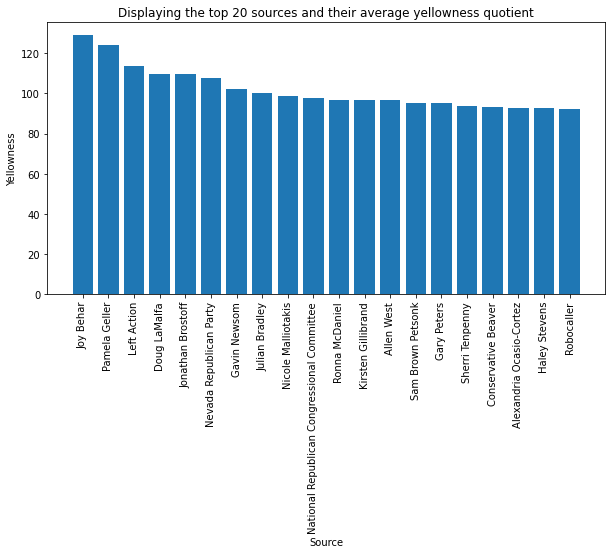

In [ ]:
##Displaying the top 20 sources and their average yellowness quotient
plt.figure(figsize=(10,5))
test_df = yellowness_df_source.head(20)
plt.bar(test_df['Source'], test_df['yellowness'])
plt.xticks(rotation=90)
plt.title('Displaying the top 20 sources and their average yellowness quotient')
plt.xlabel('Source')
plt.ylabel('Yellowness')
plt.show()

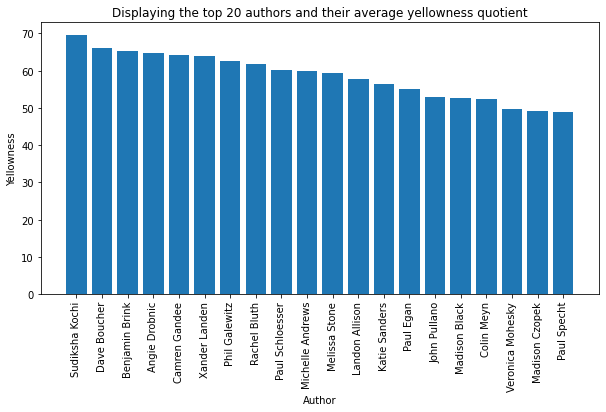

In [ ]:
##Displaying the top 20 authors and their average yellowness quotient
plt.figure(figsize=(10,5))
test_df = yellowness_df_author.head(20)
plt.bar(test_df['Author'], test_df['yellowness'])
plt.xticks(rotation=90)
plt.title('Displaying the top 20 authors and their average yellowness quotient')
plt.xlabel('Author')
plt.ylabel('Yellowness')
plt.show()

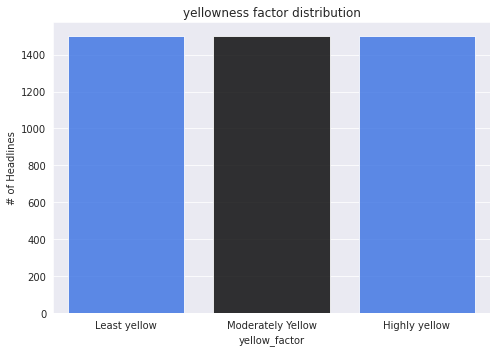

In [ ]:
#yellow_factor countplot
#visualizing yellow_factor frequency of dataset
sns.set_style('darkgrid')
plt.figure(figsize=(7,5))
fig1=sns.countplot(df_politifact['yellow_factor'], alpha =.80, palette= ['#1a66ff','black'])
plt.title('yellowness factor distribution')
plt.ylabel('# of Headlines')
plt.tight_layout()
plt.show()

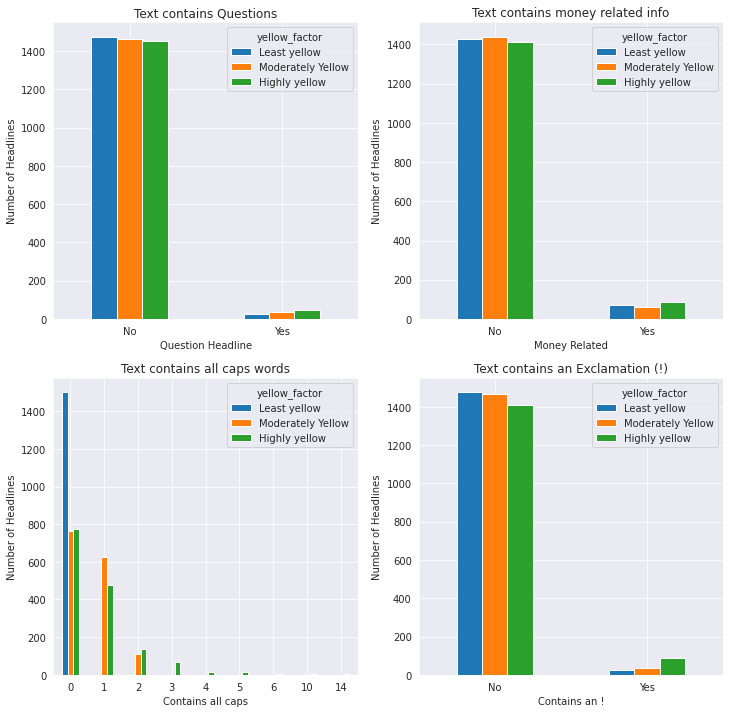

In [ ]:
#plotting engineered features to compare by yellow_factor 
import matplotlib.pyplot as plt
from matplotlib import style
sns.set_style('darkgrid')

figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

plot = df_politifact.groupby('is_q')['yellow_factor'].value_counts().unstack().plot.bar(ax=axes[0,0], rot=0)
plot.set_xlabel('Question Headline')
plot.set_ylabel('Number of Headlines')
plot.set(xticklabels=['No','Yes'])
plot.set_title('Text contains Questions')

plot = df_politifact.groupby('is_money')['yellow_factor'].value_counts().unstack().plot.bar(ax=axes[0,1], rot=0)
plot.set_xlabel('Money Related')
plot.set(xticklabels=['No','Yes'])
plot.set_ylabel('Number of Headlines')
plot.set_title('Text contains money related info')

plot = df_politifact.groupby('All_Caps')['yellow_factor'].value_counts().unstack().plot.bar(ax=axes[1,0], rot=0)
plot.set_xlabel('Contains all caps')
plot.set_ylabel('Number of Headlines')
# plot.set(xticklabels=['No','Yes'])
plot.set_title('Text contains all caps words')

plot = df_politifact.groupby('is_exclam')['yellow_factor'].value_counts().unstack().plot.bar(ax=axes[1,1], rot=0)
plot.set_xlabel('Contains an !')
plot.set_ylabel('Number of Headlines')
plot.set(xticklabels=['No','Yes'])
plot.set_title('Text contains an Exclamation (!)')

style.use('ggplot')
plt.show()

## **Modeling**
### **Implementing muller loop**




In [ ]:
#Importing required libraries
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
## Function to run various algorithms to find the best fit on our data
def muller_loop(muller_df):
  df_compare_muller = pd.DataFrame(columns=['Classifier','Accuracy/Score', 'Training Time'])
  import time as time
  import xgboost as xgb
  names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
          "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
          "Naive Bayes", "QDA", "MLP"]

  classifiers = [
      KNeighborsClassifier(2),
      SVC(kernel="linear", C=0.025),
      SVC(gamma=2, C=1),
      DecisionTreeClassifier(max_depth=5),
      RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
      MLPClassifier(alpha=1, max_iter=1000),
      AdaBoostClassifier(),
      GaussianNB(),
      QuadraticDiscriminantAnalysis(),
      MLPClassifier()]

  X = df_politifact[['flesch','is_q','is_exclam','is_money','starts_num','All_Caps','num_words','Sentiment_Score']]
  y = df_politifact[['yellow_factor']]
  X = StandardScaler().fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

  max_score = 0.0
  max_class = ''
  clf_best = ""
  model = ""
  # iterate over classifiers
  for name, clf in zip(names, classifiers):
      start_time = time.time()
      clf.fit(X_train, y_train)
      score = 100.0 * clf.score(X_test, y_test)
      print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))
      training_time = time.time() - start_time
      df_compare_muller.loc[-1] = [name, score, training_time]  # adding a row
      df_compare_muller.index = df_compare_muller.index + 1  # shifting index
      df_compare_muller = df_compare_muller.sort_index()

      if score > max_score:
          clf_best = clf
          max_score = score
          max_class = name
  print(df_compare_muller)
  print(80*'-' )
  print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
  print(80*'-' )
  print('Printing the confusion matrix for'+max_class)
  plot_confusion_matrix(clf_best, X_test, y_test, values_format=".1f", cmap=plt.cm.Reds)  
  plt.show()

  y_pred = clf_best.predict(X_test)
  print('Printing the Classification report for'+max_class)
  print(80*'-' )
  print(classification_report(y_test, y_pred))
  return df_compare_muller


Classifier = Nearest Neighbors, Score (test, accuracy) = 98.11, Training time = 0.07 seconds
Classifier = Linear SVM, Score (test, accuracy) = 69.33, Training time = 0.37 seconds
Classifier = RBF SVM, Score (test, accuracy) = 98.67, Training time = 0.26 seconds
Classifier = Decision Tree, Score (test, accuracy) = 97.67, Training time = 0.01 seconds
Classifier = Random Forest, Score (test, accuracy) = 79.22, Training time = 0.03 seconds
Classifier = Neural Net, Score (test, accuracy) = 98.78, Training time = 2.36 seconds
Classifier = AdaBoost, Score (test, accuracy) = 79.33, Training time = 0.41 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 81.56, Training time = 0.01 seconds
Classifier = QDA, Score (test, accuracy) = 60.33, Training time = 0.01 seconds
Classifier = MLP, Score (test, accuracy) = 99.56, Training time = 2.94 seconds
          Classifier  Accuracy/Score  Training Time
0                MLP       99.555556       2.940278
1                QDA       60.333333     

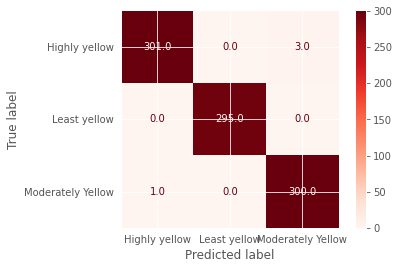

Printing the Classification report forMLP
--------------------------------------------------------------------------------
                   precision    recall  f1-score   support

    Highly yellow       1.00      0.99      0.99       304
     Least yellow       1.00      1.00      1.00       295
Moderately Yellow       0.99      1.00      0.99       301

         accuracy                           1.00       900
        macro avg       1.00      1.00      1.00       900
     weighted avg       1.00      1.00      1.00       900



,Classifier,Accuracy/Score,Training Time
0,MLP,99.555556,2.940278
1,QDA,60.333333,0.009086
2,Naive Bayes,81.555556,0.007264
3,AdaBoost,79.333333,0.408696
4,Neural Net,98.777778,2.365118
5,Random Forest,79.222222,0.033180
6,Decision Tree,97.666667,0.009792
7,RBF SVM,98.666667,0.255848
8,Linear SVM,69.333333,0.369573
9,Nearest Neighbors,98.111111,0.071803


In [ ]:
muller_loop(df_politifact)

## **References**
* https://algotrading101.com/learn/sentiment-analysis-python-guide/
* https://github.com/Lucas170/Sentiment-Analysis-1-TSLA-Headlines
* https://github.com/AlisonSalerno/clickbait_detector
* https://github.com/aarsanjani/applied-ml-2020/blob/master/MullerLoop.ipynb
* https://github.com/dhrushilbadani/YellowFever
* https://pypi.org/project/textstat/

